In [1]:
#load dataset
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
import matplotlib.pyplot as pl
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


DATASET_COLUMNS = ["target", "id", "time", "query", "to", "posts"]
data=pd.read_csv('data.csv', names=DATASET_COLUMNS , encoding='ISO-8859-1')
data.head()

,target,id,time,query,to,posts
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [2]:
#Dataset Analysis
print(data["query"].unique())
data['target'].unique()
data.dtypes

data['target'].unique()
#data['target'].nunique()

['NO_QUERY']


array([0, 4], dtype=int64)

In [3]:
data = data[['posts','target']]
data['target'] = data['target'].replace(4,1)

In [4]:
# grouping data according to target
target_grouped =  data.groupby('target')['target'].count
target_grouped


<bound method GroupBy.count of <pandas.core.groupby.generic.SeriesGroupBy object at 0x0000018AC4E0AC70>>

In [5]:
#splitting data to lists
target_list = list(data['target'])
text_list = list(data['posts'])
target_list
text_list

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing ",
 'I just re-pierced my ears ',
 "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
 '@octolinz16 It it counts, idk why I did either. you never talk to me anymore ',
 "@smarrison i wo

<AxesSubplot:xlabel='target', ylabel='count'>

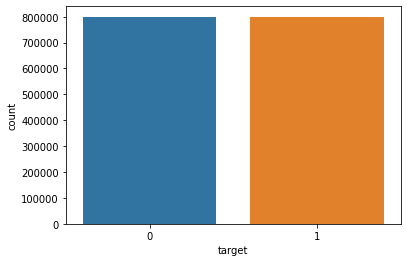

In [6]:
#visualizing data distribution according to target
import seaborn as sns
sns.countplot(x='target', data=data)

In [7]:
# spliting positive and negative data
data_pos=data[data['target']==1]
data_pos
data_neg=data[data['target']==0]

In [8]:
# #reducing data size to 25%
# data_pos=data_pos.iloc[:int(20000)]
# data_neg=data_neg.iloc[:int(20000)]
# data_neg

,posts,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
19995,"Not much time off this weekend, work trip to M...",0
19996,One more day of holidays,0
19997,feeling so down right now .. i hate you DAMN H...,0
19998,"geez,i hv to READ the whole book of personalit...",0


In [9]:
dataset = pd.concat([data_pos,data_neg])

dataset['posts']=dataset['posts'].str.lower()
# removing url
import re
pattern_url = '((www.[^s]+)|(https?://[^s]+))'
def remove_pattern(text, pattern):
    return re.sub(pattern, ' ', text)

dataset['posts'] = data['posts'].apply(lambda x: remove_pattern(x, pattern_url))
dataset

,posts,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1
...,...,...
19995,"Not much time off this weekend, work trip to M...",0
19996,One more day of holidays,0
19997,feeling so down right now .. i hate you DAMN H...,0
19998,"geez,i hv to READ the whole book of personalit...",0


In [10]:
# removing punctuations except @
import string
english_punctuations = string.punctuation
english_punctuations = english_punctuations.replace("@", "")
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['posts']= dataset['posts'].apply(lambda x: cleaning_punctuations(x))
dataset['posts'].head()


800000           I LOVE @Health4UandPets u guys r the best 
800001    im meeting up with one of my besties tonight C...
800002    @DaRealSunisaKim Thanks for the Twitter add Su...
800003    Being sick can be really cheap when it hurts t...
800004      @LovesBrooklyn2 he has that effect on everyone 
Name: posts, dtype: object

In [11]:
# removing username
import re
pattern = '@\S+'
def remove_pattern(text, pattern):
    r = re.findall(pattern,text)
    for i in r:
        text = re.sub(i,"",text)
    return text

dataset['posts'] = dataset['posts'].apply(lambda x: remove_pattern(x, pattern))
dataset['posts']

800000                           I LOVE  u guys r the best 
800001    im meeting up with one of my besties tonight C...
800002     Thanks for the Twitter add Sunisa I got to me...
800003    Being sick can be really cheap when it hurts t...
800004                      he has that effect on everyone 
                                ...                        
19995     Not much time off this weekend work trip to Ma...
19996                             One more day of holidays 
19997     feeling so down right now  i hate you DAMN HUM...
19998     geezi hv to READ the whole book of personality...
19999     I threw my sign at donnie and he bent over to ...
Name: posts, Length: 40000, dtype: object

In [12]:
#removing numbers
pattern_num = '[0-9]+'
dataset['posts'] = dataset['posts'].apply(lambda x: remove_pattern(x, pattern_num))

In [13]:
import nltk
nltk.download('punkt')
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


def clean_stop(text) :
    return " ".join([x for x in str(text).split() if x not in stopwordlist])

dataset['posts'] = dataset['posts'].apply(lambda x : clean_stop(x))
dataset['posts']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


800000                                 I LOVE u guys r best
800001    im meeting one besties tonight Cant wait GIRL ...
800002    Thanks Twitter add Sunisa I got meet HIN show ...
800003    Being sick really cheap hurts much eat real fo...
800004                                      effect everyone
                                ...                        
19995     Not much time off weekend work trip Malmï¿½ Fr...
19996                                      One day holidays
19997                       feeling right hate DAMN HUMPREY
19998     geezi hv READ whole book personality types emb...
19999     I threw sign donnie bent over get but thingee ...
Name: posts, Length: 40000, dtype: object

In [14]:
# tokenization

from nltk.tokenize import RegexpTokenizer
dataset['posts'] = dataset['posts'].apply(nltk.word_tokenize)
dataset['posts']

800000                          [I, LOVE, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, Cant, wai...
800002    [Thanks, Twitter, add, Sunisa, I, got, meet, H...
800003    [Being, sick, really, cheap, hurts, much, eat,...
800004                                   [effect, everyone]
                                ...                        
19995     [Not, much, time, off, weekend, work, trip, Ma...
19996                                  [One, day, holidays]
19997                 [feeling, right, hate, DAMN, HUMPREY]
19998     [geezi, hv, READ, whole, book, personality, ty...
19999     [I, threw, sign, donnie, bent, over, get, but,...
Name: posts, Length: 40000, dtype: object

In [15]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    data = [st.stem(word) for word in data]
    return ' '.join(data)
dataset['posts'] = dataset['posts'].apply(lambda x: stemming_on_text(x))
dataset['posts']

800000                                  i love u guy r best
800001        im meet one besti tonight cant wait girl talk
800002    thank twitter add sunisa i got meet hin show d...
800003    be sick realli cheap hurt much eat real food p...
800004                                       effect everyon
                                ...                        
19995     not much time off weekend work trip malmï¿½ fr...
19996                                       one day holiday
19997                          feel right hate damn humprey
19998     geezi hv read whole book person type embark ty...
19999     i threw sign donni bent over get but thinge ma...
Name: posts, Length: 40000, dtype: object

In [16]:
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# lt = nltk.WordNetLemmatizer()
# def lemmatizing_on_text(data):
#     data = [lt.lemmatize(word) for word in data]
#     return ' '.join(data)
# dataset['posts']= dataset['posts'].apply(lambda x: lemmatizing_on_text(x))
# dataset['posts']

In [17]:
X = dataset.posts
y = dataset.target
X


800000                                  i love u guy r best
800001        im meet one besti tonight cant wait girl talk
800002    thank twitter add sunisa i got meet hin show d...
800003    be sick realli cheap hurt much eat real food p...
800004                                       effect everyon
                                ...                        
19995     not much time off weekend work trip malmï¿½ fr...
19996                                       one day holiday
19997                          feel right hate damn humprey
19998     geezi hv read whole book person type embark ty...
19999     i threw sign donni bent over get but thinge ma...
Name: posts, Length: 40000, dtype: object

In [18]:

# from wordcloud import WordCloud 
# import matplotlib as plt
# data_neg = data['posts'][800000:]
# pl.figure(figsize = (20,20))
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#                collocations=False).generate(" ".join(str(word) for word in data_neg))
# pl.imshow(wc)

In [19]:
# data_pos = data['posts'][:800000]
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#               collocations=False).generate(" ".join(str(word) for word in data_pos))
# pl.figure(figsize = (20,20))
# pl.imshow(wc)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))



No. of feature_words:  202329


In [21]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)


In [22]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    pl.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    pl.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    pl.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [23]:
# from sklearn.ensemble import RandomForestClassifier

# rf_model = RandomForestClassifier(n_estimators=200)
# rf_model.fit(X_train,y_train)
# model_Evaluate(rf_model)
# y_pred2 = rf_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       991
           1       0.78      0.74      0.76      1009

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



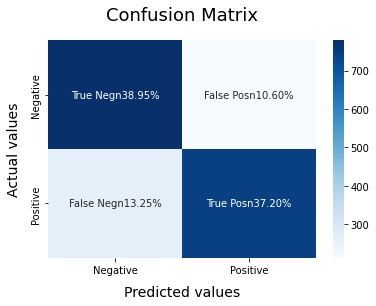

In [24]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       991
           1       0.78      0.76      0.77      1009

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



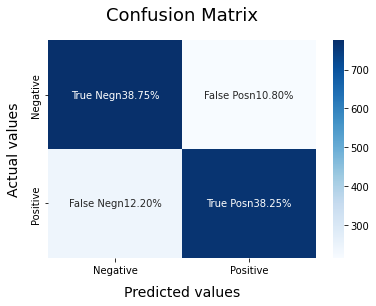

In [25]:
lrmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
lrmodel.fit(X_train, y_train)
model_Evaluate(lrmodel)
y_pred3 = lrmodel.predict(X_test)

In [26]:
# def remove_duplicate(text) :
#     return re.sub(r'(.)1+', r'1', text)
# data['posts'] = data['posts'].apply(lambda x : remove_duplicate(x))
# data['posts'][1048569]

# jatin = "jattin is a a sad sad"
# jatin=remove_duplicate(jatin)
# jatin

In [27]:
# st = nltk.PorterStemmer()
# def stemming_on_text(text):
#     return " ".join([st.stem(x) for x in str(text).split()])

# data['posts'] = data['posts'].apply(lambda x : stemming_on_text(x))
# data['posts']

In [28]:
# display(data.to_string())
# data['posts'][3]

In [29]:
# # remove punctuations
# import string
# import re
# punctuation = string.punctuation
# punctuation = punctuation.replace("@", "")
# punctuation_list = list(punctuation)

# """
# def remove_punctuation(text) :
#     for i in punctuation_list :
#         if (text.find(i)!=-1) :
#             text.replace(i, " ")
#     return text
# """

# def remove_punct(text):
#     new_words = []
#     for word in text:
#         w = re.sub(r'[^\w\s\@]','',word) #remove everything except words and space
#         w = re.sub(r'_','',w) #how to remove underscore as well
#         new_words.append(w)
#     return ''.join(str(e) for e in new_words)
    

# data['posts'] = data['posts'].apply(lambda x : remove_punct(x))
# data['posts']
# new_data = data['posts']

# #data['posts'] = data['posts'].str.replace("[^@a-zA-Z#]", " ")
# #data['posts']


In [30]:
#print(data['posts'][0])

#for i in range(80000,800000) :
#    data['posts'][i]=remove_pattern(data['posts'][i], pattern)